# Local Area Unemployment and Employment Statistics


In [1]:
# Hide warnings
#import warnings
#warnings.filterwarnings('ignore')

import sys
sys.path.append('../src')

import requests

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

# Import libraries and adjust settings
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize, LinearSegmentedColormap
plt.rc('font', family='Lato')

# CSV file contains city names, their BLS codes (Metropolitan 
# MTAs/NECTAs only), and their latitude and longitude
MSA = pd.read_csv('shapefiles/MSA.csv')

### MSA-level unemployment change

In [2]:
# BLS flat file contains the unemployment rate by month since 2015
url = 'https://download.bls.gov/pub/time.series/la/la.data.60.Metro'
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/110.0'}
r = requests.get(url, headers=headers)
t = r.content.decode()
write_txt(data_dir / 'msa.txt', t)

In [3]:
df = pd.read_csv(data_dir / 'msa.txt', sep='\s+', dtype='object')
date = lambda x: x['year'].astype('str') + '-' + x['period'].str[1:] + '-01'

data = (df[df['series_id'].isin(MSA['fullcode']) & ~df['period'].isin(['M13'])]
          .assign(DATE = date)
          .set_index(['series_id','DATE'])
          .value).unstack().T.dropna().astype('float')
data.to_csv(data_dir / 'msa_unemp_raw.csv', index_label='date')

lfs = [f'{c[:-1]}6' for c in MSA.fullcode]
data2 = (df.query('series_id in @lfs and period != "M13"')
         .assign(DATE = date).set_index(['series_id','DATE'])
         .value).unstack().T.dropna().astype('float')
data2.to_csv(data_dir / 'msa_lf_raw.csv', index_label='date')

print('Latest:', dtxt(data.index[-1])['mon1'])

Latest: August 2023


In [4]:
data = pd.read_csv(data_dir / 'msa_unemp_raw.csv', 
                   index_col='date', parse_dates=True)
ltdt = dtxt(data.index[-1])['mon1']
pr = -49 if data.index[-1] >= pd.to_datetime('2022-03-01') else -37
prtxt = 'four' if pr == -49 else 'three'
lt = data.iloc[-1].rename('latest')
pc = data.iloc[pr].rename('precov')
ch = (data.iloc[-1] - data.iloc[pr]).rename('value')
prdt = dtxt(data.index[pr])['mon1']
write_txt(text_dir / 'unemp_map_date.txt', ' to '.join([prdt, ltdt]))
ms = MSA.set_index('fullcode').join(ch).join(lt).join(pc)
ms['color'] = np.where(ms.value > 0.2, 'blue', 
                       np.where(ms.value < -0.2, 'greenyellow', 'gray'))
ms['size'] = np.where(abs(ms.value) > 0.2, (abs(ms.value*4)), 2)

In [5]:
# Labor force size and change
lf = pd.read_csv(data_dir / 'msa_lf_raw.csv', 
                   index_col='date', parse_dates=True)

lfc = [f'{c[:-1]}3' for c in lf.columns]
lf.columns = lfc
lfl = MSA.set_index('fullcode').join(lf.iloc[-1].rename('labor_force'))
lft = lfl.sort_values('labor_force', ascending=False)['labor_force']
lfch = (lf.pct_change(abs(pr)).iloc[-1] * 100).rename('LFCH').round(1)

cols = data.index[[-37, -25, -13, -4, -3, -2, -1]]
colnames = [dtxt(i)['mon2'] for i in cols]
r = data.loc[data.index[[-37, -25, -13, -4, -3, -2, -1]]].T
r.columns = colnames
pc = ((data.iloc[-1] - data.loc['2019'].mean())
      .rename('Change since 2019'))
m3lt = ((data.iloc[-3:].mean() - data.iloc[-6:-3].mean())
        .rename(dtxt(data.index[-1])['mon2'] + ' 3M'))
m3pr = ((data.iloc[-4:-1].mean() - data.iloc[-7:-4].mean())
        .rename(dtxt(data.index[-2])['mon2'] + ' 3M'))
m12 = data.diff(12).iloc[-2:].T
m12.columns = [f'{i} 12M' for i in colnames[-2:]]
if 'Apr 2020' not in colnames:
    cov = data.loc['2020-04-01'].rename('Apr 2020')
    r = r.join(cov)
r = r.join(m3pr).join(m3lt).join(m12).join(pc).round(1).join(lft).join(lfch)
final = MSA.set_index('fullcode')[['fullname', 'area_code']].join(r)
final.to_csv(data_dir / 'msa_unemp_rate.csv', index_label='BLSID')

incn = len(ch[ch > 0.2])
decn = len(ch[ch < -0.2])
samen = len(ch[(ch <= 0.2) & (ch >= -0.2)])
text = (f'From {prdt} to {ltdt}, unemployment rates fell by 0.3 '+
        f'percentage point or more in {decn} metro areas, and '+
        f'increased by 0.3 percentage point or more in {incn} metro '+
        'areas. Recent local unemployment rates were within 0.2 '+
        'percentage points of their pre-pandemic level in '+
        f'{samen} metro areas. ')
write_txt(text_dir / 'msa_unemp_ch_n.txt', text)
print(text)
ms10 = (ms.join(lft).join(lfch).dropna()
          .sort_values('labor_force', ascending=False).iloc[:11])

From August 2019 to August 2023, unemployment rates fell by 0.3 percentage point or more in 176 metro areas, and increased by 0.3 percentage point or more in 142 metro areas. Recent local unemployment rates were within 0.2 percentage points of their pre-pandemic level in 69 metro areas. 


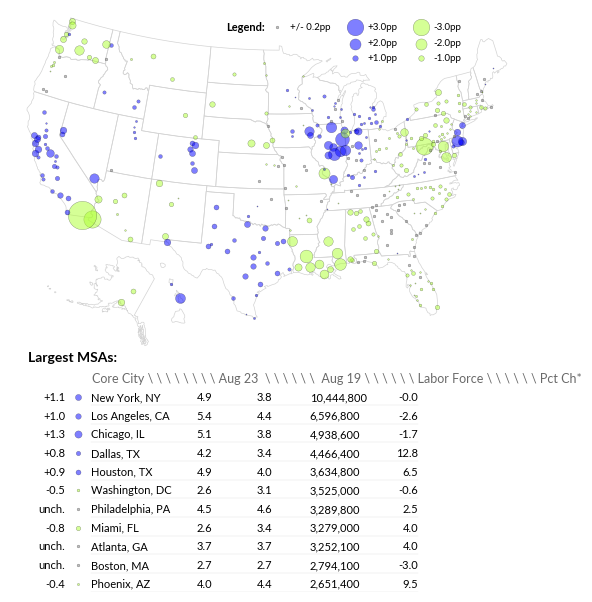

In [6]:
# Map and legend settings
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 2.5]}, 
                              figsize=(6.5,8.0))
m = Basemap(llcrnrlon=-119, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile('shapefiles/states', 'st', drawbounds=True, color='lightgrey', ax=ax)
   
for info, shape in zip(m.st_info, m.st):
    if info['STATE_NAME'] == 'Hawaii':
        shape2 = [[x + 5200000, y - 1400000] for x, y in shape]
        ax.add_patch(Polygon(shape2, fc='white', ec='lightgray', lw=0.5)) 
    elif info['STATE_NAME'] == 'Alaska':
        shape2 = [(x * 0.34 + 1200000, 
                  y * 0.34 - 1300000) for x, y in shape]
        ax.add_patch(Polygon(shape2, fc='white', ec='lightgray', lw=0.5))    
        
# Plot each location, value, and color as identified in the previous section        
for index, row in ms.iterrows():
    x, y = m(row['longitude'], row['latitude'])
    if row['fullname'].endswith('HI'):
        x = x + 5200000
        y = y - 1400000
    if row['fullname'].endswith('AK'):
        x = x * 0.34 + 1200000
        y = y * 0.34 - 1300000
    ax.plot(x, y, marker='o', color=row['color'], alpha=0.5, markersize=row['size'], 
           markeredgecolor='black', markeredgewidth=.25)

plt.annotate('Legend:', xy=(0.43, 0.94), xycoords=ax, fontsize=8, 
             fontweight='bold')
legs = [(0.53, 0.95, 'gray', 2, '+/- 0.2pp'), (0.685, 0.95, 'blue', 12, '+3.0pp'), 
        (0.685, 0.905, 'blue', 8, '+2.0pp'), (0.685, 0.86, 'blue', 4, '+1.0pp'),
        (0.815, 0.95, 'greenyellow', 12, '-3.0pp'), 
        (0.815, 0.905, 'greenyellow', 8, '-2.0pp'), 
        (0.815, 0.86, 'greenyellow', 4, '-1.0pp')]

for x, y, color, size, text in legs:
    y2 = y - 0.005 if y == 0.905 else y
    ax.plot(x, y2, marker='o', color=color, alpha=0.5, markersize=size, 
            markeredgecolor='black', markeredgewidth=.25, transform=ax.transAxes) 
    ax.annotate(text, xy=(x + 0.025, y * 0.99), xycoords=ax, fontsize=7)
ax.axis('off')

for i, row in ms10.reset_index().iterrows():
    ax2.plot(0.135, 0.95 - (i / 11), marker='o', color=row['color'], 
             alpha=0.5, markersize=row['size'], markeredgecolor='black', 
             markeredgewidth=.25, transform=ax2.transAxes) 
    #val = f'{row["value"]:.1f}pp' if round(abs(row['value']), 1) > 0 else 'unch.'
    ax2.annotate(row['fullname'], xy=(0.16, 0.93 - (i / 11)), xycoords=ax2, fontsize=8)
    ax2.annotate(row['latest'], xy=(0.37, 0.93 - (i / 11)), xycoords=ax2, fontsize=8)
    ax2.annotate(row['precov'], xy=(0.49, 0.93 - (i / 11)), xycoords=ax2, fontsize=8)
    pos = '+' if row['value'] > 0 else ''
    val = f'{pos}{row["value"]:.1f}' if round(abs(row['value']), 1) > 0.2 else 'unch.'
    ax2.annotate(val, xy=(0.11, 0.93 - (i / 11)), xycoords=ax2, fontsize=8, ha='right')
    lfv = f"{round(row['labor_force'], -2):,.0f}"
    ax2.annotate(lfv, xy=(0.595, 0.93 - (i / 11)), xycoords=ax2, fontsize=8)
    lfch = f"{row['LFCH']:.1f}"
    ax2.annotate(lfch, xy=(0.81, 0.93 - (i / 11)), xycoords=ax2, fontsize=8, ha='right')
    ax2.plot([0.16, 0.81], [0.91 - (i / 11)]*2, transform=ax2.transAxes, linewidth=0.25, 
               color='gainsboro')

    
ax2.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.text(-0.051, 0.068, 'Largest MSAs:', weight='bold')
mo1, mo2 = dtxt(lf.index[-1])['mon7'], dtxt(lf.index[pr])['mon7']
header = (f'Core City \ \ \ \ \ \ \ \ {mo1}  '+
          f'\ \ \ \ \ \  {mo2} \ \ \ \ \ \ Labor'+
          ' Force \ \ \ \ \ \ Pct Ch*')
plt.text(-0.037, 0.057, header, fontsize=9, color='dimgray')

plt.savefig(data_dir / 'unemp_msa.pgf', bbox_inches='tight')

### State data

In [7]:
# BLS flat file contains the unemployment rate by month since 2015
url = 'https://www.bls.gov/web/laus/ststdnsadata.txt'
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/110.0'}
r = requests.get(url, headers=headers)

In [8]:
#laus_raw_url = 'https://www.bls.gov/web/laus/ststdnsadata.txt'
#r = requests.get(laus_raw_url)
raw_data = [line for line in r.text.split('\n')[16:] 
            if line[:2] != '\r']

epop, unrate = {}, {}

for row in raw_data:
    if row[:5] == '     ':
        date_text = row.strip().replace('\r', '')
        date = pd.to_datetime(date_text)
        epop[date], unrate[date] = {}, {}
    if len(row) > 0:
        if row[0] != ' ':
            state = row.split('.')[0].strip()
            unrate_val = float(row.split()[-1])
            unrate[date][state] = unrate_val
            epop_val = float(row.split()[-3])
            epop[date][state] = epop_val

df1 = pd.DataFrame(epop).T
df1.to_csv(data_dir / 'state_epop.csv', index_label='date')
df2 = pd.DataFrame(unrate).T
df2.to_csv(data_dir / 'state_unrate.csv', index_label='date')

### State-level unemployment

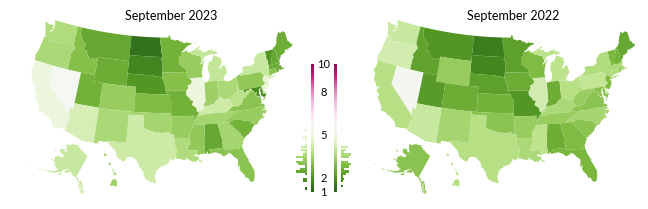

In [9]:
data = pd.read_csv(data_dir / 'state_unrate.csv', 
                   index_col='date', parse_dates=True)

# Map settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile('shapefiles/states', 'states', drawbounds=False);

states = list(set([i['STATE_NAME'] for i in m.states_info]))
vmin=1
vmax=10
cmap = plt.cm.PiYG_r
norm = Normalize(vmin=vmin, vmax=vmax)

# Draw map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.4))
fig.tight_layout()

for group, axval in [(-1, 0), (-13, 1)]:
    plt.sca(axes[axval])
    axes[axval].axis('off')
    m.drawmapboundary()
    
    for info, shape in zip(m.states_info, m.states):
        
        fc = cmap(norm(data[info['STATE_NAME']].iloc[group]))
        # Alaska and Hawaii moved
        if info['STATE_NAME'] == 'Hawaii':
            shape = [(x + 5200000, y - 1400000) for x,y in shape]
        elif info['STATE_NAME'] == 'Alaska':
            shape = [(x*0.35 + 1100000, y*0.35 - 1300000) for x,y in shape]
        axes[axval].add_patch(Polygon(shape, fc=fc))
    
    date = dtxt(data.index[group])['mon1']
    plt.text(0.4, 0.98, date, fontsize=9, 
             transform=axes[axval].transAxes)
    
ax_inset = inset_axes(axes[0], width='-30%', height='70%', loc=4, borderpad=0.5)
for tick_label in [1, 2, 5, 8, 10]:
    plt.text(0.6, norm(tick_label), tick_label, fontsize=8, 
             ha='center', va='center', transform=ax_inset.transAxes)
ax_inset.axis('off')

# Draw custom legend
for group, pt, pt2 in [(-1, 0.71, 0.8), (-13, 0.44, 0.4)]:
    for i in np.linspace(1,10,56):
        rect = Rectangle(xy=(pt, norm(i)), width=0.04, height=1/56, 
                         fc=cmap(norm(i)), ec=None)
        ax_inset.add_patch(rect)    
    
    bins = pd.cut(data.iloc[group], np.linspace(1,10,54)).apply(lambda x: x.left)
    res = data.iloc[group].groupby(bins).count()
    for i, v in res.items():
        if group == -1:
            adj = (v / 50)
        else:
            adj = 0
        if v > 0:
            rect = Rectangle(xy=(pt2 + adj, norm(i)), width= -(v / 50), 
                             height=1/54, fc=cmap(norm(i)), ec=None)
            ax_inset.add_patch(rect)    
    
plt.savefig('../chartbook/data/unemp_map.pgf', bbox_inches='tight')

In [10]:
ltmonth = dtxt(data.index[-1])['mon1']
prmonth = dtxt(data.index[-4])['mon1']
d1 = data.iloc[-1].sort_values()
d1t = d1.rename({'District of Columbia': 
                 'the District of Columbia'})
dap = data.loc['2020-04-01'].sort_values()
dpr = data.iloc[-4].sort_values()
a10 = len(d1[d1 > 8])
if a10 < 10:
    a10 = numbers2[a10]
a10 = a10 + ' states' if a10 != 'one' else 'one state'    
a10pr = len(dpr[dpr > 8])
if a10pr < 10:
    a10pr = numbers2[a10pr]
a10pr = a10pr + ' states' if a10pr != 'one' else 'one state'
a10ap = len(dap[dap > 8])
if a10ap < 10:
    a10ap = numbers2[a10ap] 
    
a5pr = len(dpr[dpr > 5])
if a5pr < 10:
    a5pr = numbers2[a5pr]
a5pr = a5pr + ' states were' if a5pr != 'one' else 'one state was'    
a5 = len(d1[d1 > 5])
if a5 < 10:
    a5 = numbers2[a5]
a5 = a5 + ' states' if a5 != 'one' else 'one state'    
h, l = {}, {}
for i in [1, 2, 3]:
    h[i] = f'{d1t.index[-i]} ({d1t.iloc[-i]}\%)'
    l[i] = f'{d1t.index[i-1]} ({d1t.iloc[i-1]}\%)'
    
st1 = (f'the unemployment rate was above eight percent in {a10} '+
       f'and above five percent in {a5}.')
st2 = ("all 50 states and DC had unemployment rates below eight percent, and "+
       f'the unemployment rate was above five percent in {a5}.')
stxt = st2 if a10 == 'no states' else st1    
    
text = (f'In {ltmonth}, {stxt} Three months prior, in {prmonth}, '+
        f'{a10pr} unemployment rate was above eight percent, '+
        f'and {a5pr} above five percent. '+
        f'In the peak of the COVID-19 pandemic shutdowns, in '+
        f'April 2020, the unemployment rate was above eight percent in '+
        f'{a10ap} states, and above five percent in every state.\n\n'+
        'The states with the highest unemployment rates in '+
        f'{ltmonth} are {h[1]}, {h[2]}, and {h[3]}. The states with '+
        f'the lowest unemployment rates are {l[1]}, {l[2]}, and {l[3]}.')
write_txt(text_dir / 'state_unemp.txt', text)
print(text)

In September 2023, all 50 states and DC had unemployment rates below eight percent, and the unemployment rate was above five percent in two states. Three months prior, in June 2023, no states unemployment rate was above eight percent, and two states were above five percent. In the peak of the COVID-19 pandemic shutdowns, in April 2020, the unemployment rate was above eight percent in 48 states, and above five percent in every state.

The states with the highest unemployment rates in September 2023 are Nevada (5.4\%), the District of Columbia (5.3\%), and California (4.9\%). The states with the lowest unemployment rates are North Dakota (1.3\%), South Dakota (1.7\%), and Maryland (1.8\%).


### Employment rate by state

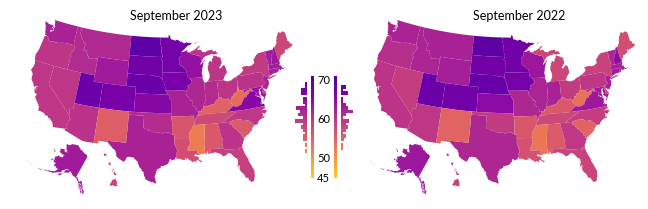

In [11]:
data = pd.read_csv(data_dir / 'state_epop.csv', 
                   index_col='date', parse_dates=True)

# Map settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)
m.readshapefile('shapefiles/states', 'states', drawbounds=False);

vmin=data.min().min()
vmax=data.max().max()
cmap = plt.cm.plasma_r
norm = Normalize(vmin=vmin, vmax=vmax)

# Draw map
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.4))
fig.tight_layout()

for group, axval in [(-1, 0), (-13, 1)]:
    plt.sca(axes[axval])
    axes[axval].axis('off')
    m.drawmapboundary()
    
    for info, shape in zip(m.states_info, m.states):
        
        fc = cmap(norm(data[info['STATE_NAME']].iloc[group]))
        # Alaska and Hawaii moved
        if info['STATE_NAME'] == 'Hawaii':
            shape = [(x + 5200000, y - 1400000) for x,y in shape]
        elif info['STATE_NAME'] == 'Alaska':
            shape = [(x*0.35 + 1100000, y*0.35 - 1300000) for x,y in shape]
        axes[axval].add_patch(Polygon(shape, fc=fc))
    
    date = dtxt(data.index[group])['mon1']
    plt.text(0.42, 0.98, date, fontsize=9, 
             transform=axes[axval].transAxes)
    
ax_inset = inset_axes(axes[0], width='-30%', height='70%', loc=4, borderpad=0.5)
for tick_label in [45, 50, 60, 70]:
    plt.text(0.6, norm(tick_label), tick_label, fontsize=8, 
             ha='center', va='center', transform=ax_inset.transAxes)
ax_inset.axis('off')

# Draw custom legend
for group, pt, pt2 in [(-1, 0.71, 0.8), (-13, 0.44, 0.4)]:
    for i in np.linspace(45,70,40):
        rect = Rectangle(xy=(pt, norm(i)), width=0.04, height=1/35, 
                         fc=cmap(norm(i)), ec=None)
        ax_inset.add_patch(rect)    
    
    bins = pd.cut(data.iloc[group], np.linspace(45,70,33)).apply(lambda x: x.left)
    res = data.iloc[group].groupby(bins).count()
    for i, v in res.items():
        if group == -1:
            adj = (v / 50)
        else:
            adj = 0
        if v > 0:
            rect = Rectangle(xy=(pt2 + adj, norm(i)), width= -(v / 50), 
                             height=1/33, fc=cmap(norm(i)), ec=None)
            ax_inset.add_patch(rect)    
    
plt.savefig('../chartbook/data/epop_map.pgf', bbox_inches='tight')

In [12]:
ltmo = dtxt(data.index[-1])['mon1']
prmo = dtxt(data.index[-13])['mon1']
d1 = data.iloc[-1].sort_values()
d1t = d1.rename({'District of Columbia': 
                 'the District of Columbia'})
dap = data.loc['2020-04-01'].sort_values()
dpr = data.iloc[-13].sort_values()
a60 = len(d1[d1 < 60])
if a60 < 10:
    a60 = numbers[f'{a60:.1f}']
a60pr = len(dpr[dpr < 60])
if a60pr < 10:
    a60pr = numbers[f'{a60pr:.1f}']
a60ap = len(dap[dap < 60])
if a60ap < 10:
    a60ap = numbers[f'{a60ap:.1f}'] 
    
a65pr = len(dpr[dpr > 65])
if a65pr < 10:
    a65pr = numbers[f'{a65pr:.1f}']
    
a65 = len(d1[d1 > 65])
if a65 < 10:
    a65 = numbers[f'{a65:.1f}']
    
h, l = {}, {}
for i in [1, 2, 3]:
    h[i] = f'{d1t.index[-i]} ({d1t.iloc[-i]}\%)'
    l[i] = f'{d1t.index[i-1]} ({d1t.iloc[i-1]}\%)'
    
text = (f'In {ltmo}, the age 16 and older employment rate is '+
        f'below 60 percent in {a60} states. One year prior, in '+
        f'{prmo}, the employment rate was below 60 percent in '+
        f'{a60pr} states. The rate is above 65 percent '+
        f'in {a65} states, in the latest month, and in {a65pr} '+
        f'states in {prmo}.\n\n'+
        'The states with the highest employment rates in '+
        f'{ltmo} are {h[1]}, {h[2]}, and {h[3]}. '+
        'The states with the lowest employment rates are '+
        f'{l[1]}, {l[2]}, and {l[3]}.')
write_txt(text_dir / 'state_emp.txt', text)
print(text)  

In September 2023, the age 16 and older employment rate is below 60 percent in 22 states. One year prior, in September 2022, the employment rate was below 60 percent in 23 states. The rate is above 65 percent in eight states, in the latest month, and in eight states in September 2022.

The states with the highest employment rates in September 2023 are North Dakota (68.5\%), the District of Columbia (68.1\%), and Nebraska (67.6\%). The states with the lowest employment rates are Mississippi (51.9\%), West Virginia (53.5\%), and Kentucky (54.6\%).
